# Section 4.1.5. Diffusion Models (Denosing Diffusion Probabilistic Model)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from utils import *

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# -------------------------------
# Define Diffusion Model related hyperparameters
# -------------------------------
def setup_diffusion_hyperparams(T):
    betas = torch.linspace(1e-4, 0.02, T).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)
    return betas, alphas, alphas_cumprod, alphas_cumprod_prev, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod

# -------------------------------
# Define time embedding and Diffusion Model
# -------------------------------
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Sinusoidal timestep embedding
    """
    half_dim = embedding_dim // 2
    emb_scale = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device).float() * -emb_scale)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embedding_dim=128):
        super(DiffusionModel, self).__init__()
        self.time_embedding_dim = time_embedding_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        """
        x: noisy input data, shape (batch_size, input_dim)
        t: time steps, shape (batch_size,)
        """
        t_emb = get_timestep_embedding(t, self.time_embedding_dim)  # (batch_size, time_embedding_dim)
        x_t = torch.cat([x, t_emb], dim=1)  # (batch_size, input_dim + time_embedding_dim)
        return self.net(x_t)  # predicted noise (batch_size, input_dim)

def forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    Outputs a noisy sample x_t and the added noise given the original sample x0 and timestep t.
    """
    noise = torch.randn_like(x0).to(device)
    sqrt_alpha_prod = sqrt_alphas_cumprod[t].view(-1, 1)  # (batch_size, 1)
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alphas_cumprod[t].view(-1, 1)  # (batch_size, 1)
    x_t = sqrt_alpha_prod * x0 + sqrt_one_minus_alpha_prod * noise
    return x_t, noise

## 1. Training Stage

In [3]:
# -------------------------------
# Loss function
# -------------------------------
def compute_diffusion_loss(model, x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    Do a forward diffusion with the given x0 and timestep t,
    compute the MSE between the noise predicted by the model and the actual noise.
    """
    x_t, noise = forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noise_pred = model(x_t, t)
    loss = nn.functional.mse_loss(noise_pred, noise)
    return loss

# -------------------------------
# Training
# -------------------------------
def train_diffusion_model(model, dataloader, optimizer, epochs, T, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    For each batch, sample a random timestep between 0 and T-1, add noise and compute loss.
    """
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for batch in dataloader:
            x0 = batch[0].to(device)
            b_size = x0.size(0)
            # sample a random timestep for each batch
            t = torch.randint(0, T, (b_size,), device=device).long()
            loss = compute_diffusion_loss(model, x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        if epoch % 2 == 0 or epoch == 1:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}')

In [4]:
filepath = '../dataset/hts_example.csv'
hidden_dim = 256
T = 1000  # Num of diffusion step
betas, alphas, alphas_cumprod, alphas_cumprod_prev, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = setup_diffusion_hyperparams(T)
time_embedding_dim = 128
learning_rate = 1e-3
batch_size = 512
epochs = 30

ground_truth_df, data_tensor, num_categories = load_and_preprocess_data(filepath, device)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = data_tensor.shape[1]

# Diffusion Model
diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, time_embedding_dim=time_embedding_dim).to(device)
optimizer = optim.Adam(diffusion_model.parameters(), lr=learning_rate)

train_diffusion_model(diffusion_model, dataloader, optimizer, epochs, T, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.
Epoch [1/30], Loss: 0.324467
Epoch [2/30], Loss: 0.273908
Epoch [4/30], Loss: 0.259855
Epoch [6/30], Loss: 0.253885
Epoch [8/30], Loss: 0.250940
Epoch [10/30], Loss: 0.250945
Epoch [12/30], Loss: 0.250245
Epoch [14/30], Loss: 0.248510
Epoch [16/30], Loss: 0.246935
Epoch [18/30], Loss: 0.248289
Epoch [20/30], Loss: 0.246897
Epoch [22/30], Loss: 0.246614
Epoch [24/30], Loss: 0.247660
Epoch [26/30], Loss: 0.244866
Epoch [28/30], Loss: 0.244913
Epoch [30/30], Loss: 0.243534


## 2. Testing Stage

In [5]:
def generate_diffusion_samples(model, num_samples, sample_dim, T, betas, alphas):
    """
    For each sample, generate a sample by running the reverse diffusion process.
    Start with initial x as Gaussian noise and gradually recover over T steps.
    """
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, sample_dim).to(device)
        for t in reversed(range(T)):
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
            noise_pred = model(x, t_tensor)
            beta_t = betas[t].view(1, 1).to(device)
            # if t > 0, add noise, else no noise
            noise = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
            x = (x - beta_t * noise_pred) / torch.sqrt(alphas[t]) + torch.sqrt(beta_t) * noise
            x = torch.clamp(x, -10, 10)
        return x

def map_to_categories(x, columns, num_categories):
    """
    Convert the generated continuous sample x to discrete categories.
    """
    generated_df = pd.DataFrame(x.cpu().numpy(), columns=columns)
    for column in columns:
        max_cat = num_categories[column] - 1
        generated_df[column] = np.floor(generated_df[column]).astype(int)
        generated_df[column] = np.clip(generated_df[column], 0, max_cat)
    return generated_df

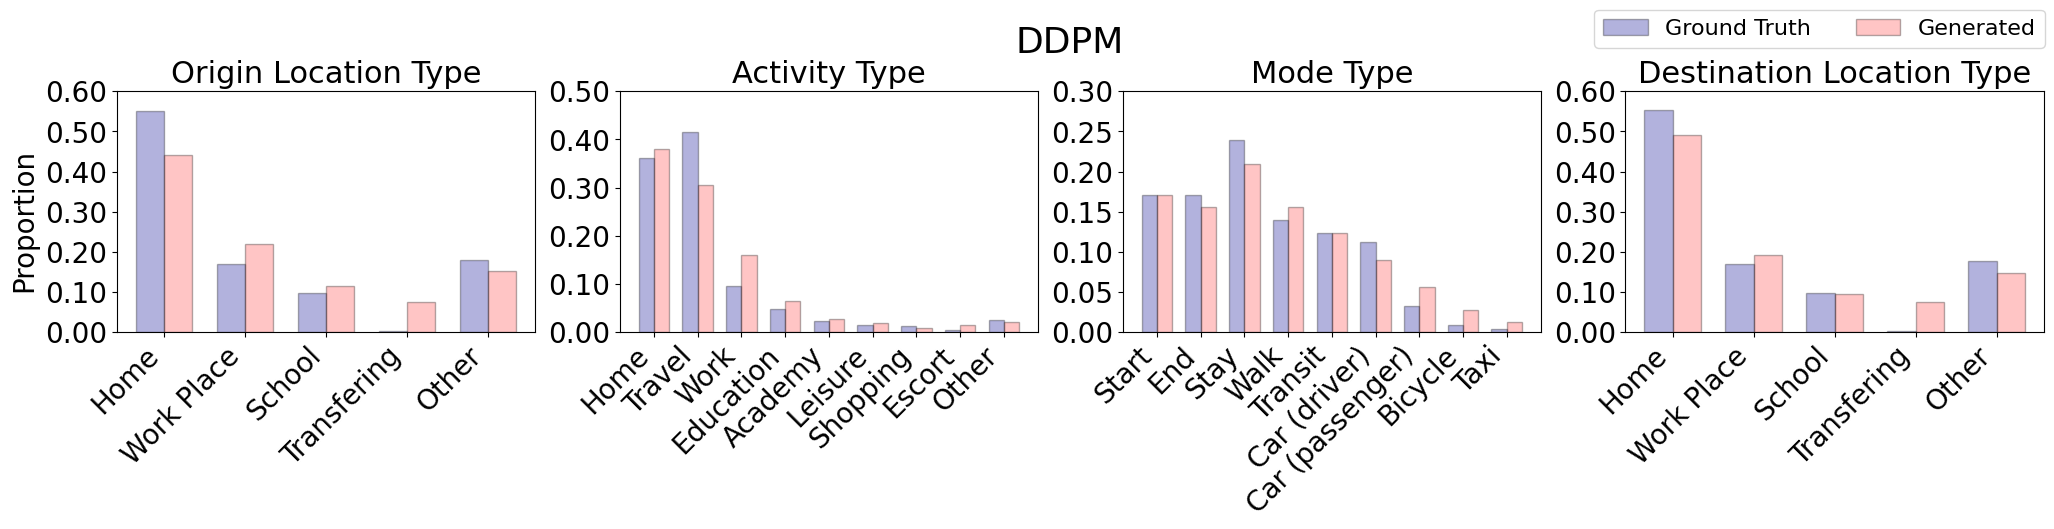


Aggregate Performance Metrics:
--------------------------------------------------
Average MSE: 0.0021141
Average MAE: 0.0334635
Average KLD: 0.0549383

SRMSE for 2-Column Combinations:
--------------------------------------------------
('start_type', 'act_num'): 1.2181610
('start_type', 'mode_num'): 0.9712181
('start_type', 'end_type'): 0.7295660
('act_num', 'mode_num'): 1.6481936
('act_num', 'end_type'): 1.0676908
('mode_num', 'end_type'): 0.9325686

[Average SRMSE across all 6 combos] = 1.0945664


In [6]:
model_name = 'DDPM'
diffusion_model.eval()
num_samples = 3000

columns = ['start_type', 'act_num', 'mode_num', 'end_type']
x_generated = generate_diffusion_samples(diffusion_model, num_samples, len(columns), T, betas, alphas)
generated_df = map_to_categories(x_generated, columns, num_categories)

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],   # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']      # End Location Type
]

visualize_results(model_name, ground_truth_df, generated_df, columns, xtick_labels_list)

avg_mse, avg_mae, avg_kld, srmse_dict = evaluate_model(ground_truth_df, generated_df, columns)